# Pre processing steps of a COCO JSON annotated file

Given a single COCO annotated JSON file, your goal is to pre-process in order to remove noise and manipulate it into a form which is suitable for training a ML model. This script will also check if the annotated images are broken or missing.The output of this notebook should be 2 JSON annotation files -
`Material and its sub type (e.g Plastics_HDPE)` and `'Material form and its sub type (e.g.Paper-Products-White-Paper)'`

The COCO annotation file includes the following -

1. Name of the images.

2. Dimensions of the images.

3. Classes in the image category.

4. Name of the super categories of the classes.

5. Area acquired by the segmented pixels in an image.

6. Bounding box co-ordinates.

7. Annotated segmentation coordinates.

There is a lot of noise in the real world annotation file. The images name could be wrong. The images mentioned in an annotation file may not be present in the image folder, which will disrupt the model training procedure. The contents within an annotation file may not match with each other. Even the files present in an image folder may be broken or truncated, which will cause errors while reading image files. Our goal is to eradicate all these problems.

Our goal is to make sure that all information in the key values corresponds to each other correctly. This notebook will help you achieve this task.

## Import labels and sample JSON file
To import total classes for the material, material_form and plastic_type we will import the label files from the waste_identification_ml project from Tensorflow Model Garden.
We will also import a noisy sample JSON file to illustrate an example.

In [ ]:
%%bash
curl -O "https://raw.githubusercontent.com/tensorflow/models/master/official/"\
"projects/waste_identification_ml/two_model_inference/labels.py"

curl -O "https://raw.githubusercontent.com/tensorflow/models/master/official/"\
"projects/waste_identification_ml/pre_processing/config/sample_json/dataset.json"


curl -O "https://raw.githubusercontent.com/tensorflow/models/master/official/"\
"projects/waste_identification_ml/pre_processing/config/data/"\
"two_model_strategy_material.csv"

curl -O "https://raw.githubusercontent.com/tensorflow/models/master/official/"\
"projects/waste_identification_ml/pre_processing/config/data/"\
"two_model_strategy_material_form.csv"

mkdir image_folder

curl -o image_folder/image_2.png "https://raw.githubusercontent.com/"\
"tensorflow/models/master/official/projects/waste_identification_ml/"\
"pre_processing/config/sample_images/image_2.png"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3862  100  3862    0     0  18499      0 --:--:-- --:--:-- --:--:-- 18567
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2427  100  2427    0     0   8695      0 --:--:-- --:--:-- --:--:--  8667
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   264  100   264    0     0    935      0 --:--:-- --:--:-- --:--:--   936
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   422  100   422    0     0   1525      0 --:--:-- --:--:-- --:--:--  1528
mkdir: cannot create directory ‘image_folder’: File 

## Import the required libraries

In [ ]:
import glob
import tqdm
import json
from PIL import Image
import subprocess
import copy
import os
from google.colab import files
from labels import load_labels

In [ ]:
# @title Utility Functions { display-mode: "form", run: "auto" }
def read_json(file):
  """Read any JSON file.

  Args:
    file: path to the file
  """
  with open(file) as json_file:
    data = json.load(json_file)
  return data


def search_dict_value(dic, id):
  """Returns the key of the dictionary from its value'

  Args:
    dic = Mapping to search by value.
    id = Value to search.
  """
  key_list = list(dic.keys())
  val_list = list(dic.values())
  position = val_list.index(id)
  return key_list[position]


def delete_truncated_images(folder_path: str) -> None:
  """Find and delete truncated images.

  Args:
    folder_path: path to the folder where images are saved.
  """
  # path to the images folder to read its content
  files = glob.glob(folder_path + '/*')
  print('Total number of files in the folder:', len(files))

  num = 0

  # read all image files and remove them from the directory in case they are broken
  for file in tqdm.tqdm(files):
    if file.endswith(('.png','.jpg')):
      try:
        img = Image.open(file)
        img.verify()
      except:
        num = num + 1
        subprocess.run(['rm', file])
        print('Broken file name:  ' + file)
  if num == 0:
    print('\nNo broken images found')
  else:
    print('Total number of broken images found:', num)


def spelling_correction(dic, typo_dict):
  """Correcting some common spelling mistakes."""
  for i in dic['categories']:
    for old, new in typo_dict.items():
      i['name'] = i['name'].replace(old, new)
  return dic


def labeling_correction(dic, labels_dict, num):
  """Matching annotated labels with the correct labels.

  Mapping the modified labeling ID with the corresponding original ID for alignment
  of categories.

  Args:
    dic: JSON file read as a dictionary
    num: keyword position inside the label
    labels_dict: dictionary showing the labels ID of the original categories
  """
  mapping_list = []
  incorrect_labels = []

  for i in dic['categories']:
      sp = i['name'].split('_')

      if num == 1:
          target_value = sp[0].lower() + '_' + sp[1].lower()
      elif num == 4:
          target_value = sp[4].lower()
      else:
          raise ValueError("Invalid value for 'num'")

      if target_value in labels_dict.values():
          id_match = search_dict_value(labels_dict, target_value)
          mapping_list.append((i['id'], target_value, id_match))
      else:
          incorrect_labels.append(i['id'])

  return mapping_list, incorrect_labels


def images_key(dic):
  """Align the data within the dictionary in the 'images' key.

  The 'image_id' parameter in the 'annotation' key is the same as 'id' in the 'images' key of the dictionary. This function
  will also remove all image data from the 'images' key whose 'id' does not
  match with 'image_id' in the 'annotation' key in the dictionary.

  Args:
    dic: where the JSON file is read into
  """
  image_ids = set(i['image_id'] for i in dic['annotations'])
  new_images = [i for i in dic['images'] if i['id'] in image_ids]
  return new_images


def annotations_key(dic, incorrect_labels, mapping_dict):
  """Align the data within the dictionary  in the 'annotation' key.

  Notice that the 'category_id' in the 'annotation' key is same as 'id'
  in the 'categories' key of the dictionary.

  Args:
    dic: where the JSON file is read into
  """
  new_annotation = []

  for i in dic['annotations']:
    id = i['category_id']
    if (id not in incorrect_labels) and (id in [tup[0] for tup in mapping_dict]):
      new_id = [i[2] for i in mapping_dict if i[0] == id][0]
      i['category_id'] = new_id
      new_annotation.append(i)
  return new_annotation


def annotated_images(folder_path, dic):
  """Get images infromation that are mentioned in an annotation file but are not present in an image folder.

  Args:
    folder_path: path of an image folder.
  """
  # read the file names from the directory
  files = glob.glob(folder_path + '/*')
  files = set(map(os.path.basename, files))

  # list of images in an annotation file
  dic['images'] = [i for i in dic['images'] if i['file_name'] in files]
  return dic


def image_annotation_key(dic):
  """Check if same images are present in both "images" key and "annotations" key.

  List of the image IDs which are in the "images" key but NOT in "annotation" key.
  Remove information if they are not present in both keys.

  Args:
    dic: annotation file read as a dictionary
  """
  images_id = [i['id'] for i in dic['images']]
  annotation_id = [i['image_id'] for i in dic['annotations']]
  common_list = set(images_id).intersection(annotation_id)
  dic['images'] = [i for i in dic['images'] if i['id'] in common_list]
  dic['annotations'] = [i for i in dic['annotations'] if i['image_id'] in common_list]
  return dic


def categories_dictionary(list_of_objects):
  """Generates a list of dictionaries representing categories of objects.

  Each dictionary has an 'id' corresponding to its order in the list, a 'name'
  taken from the input list, and a fixed 'supercategory' set as 'objects'.

  Args:
      list_of_objects: List of object names to be used as categories.

  Returns:
      list: List of dictionaries, each representing a category.

  Example:
      >>> categories_dictionary(['car', 'bus'])
      [{'id': 1, 'name': 'car', 'supercategory': 'objects'},
        {'id': 2, 'name': 'bus', 'supercategory': 'objects'}]
  """
  objects_dictionaries = []
  for num, m in enumerate(list_of_objects, start=1):
    objects_dictionaries.append({
        'id': num,
        'name': m,
        'supercategory': 'objects'
    })

  return objects_dictionaries


def print_incorrect_labels(incorrect_labels, data_postprocessing, m):
    """Prints the incorrect labels and their count.

    Args:
        incorrect_labels: List of incorrect label IDs.
        data_postprocessing: The data containing postprocessing details.
        m: A tuple where the element denotes a condition value.
    """
    print('\nTotal number of incorrect labels:', len(incorrect_labels))
    print('Incorrect labels are below: ')

    for category in data_postprocessing['categories']:
        if category['id'] in incorrect_labels:
            name_parts = category['name'].split('_')

            if m == 1 and len(name_parts) >= 2:
                print(f'{name_parts[0]}_{name_parts[1]}')
            elif m == 4 and len(name_parts) >= 5:
                print(name_parts[4])
    print('')


def print_dict_characteristics(stage_num, dic):
    """Prints characteristics of the dictionary after post processing.

    Args:
        stage_num: The stage number of post processing.
        data_postprocessing: The data containing postprocessing details.
    """
    print(f'Dictionary characteristics after post processing stage {stage_num}:')
    print('images:', len(dic['images']),
          'categories:', len(dic['categories']),
          'annotations:', len(dic['annotations']))

In [ ]:
LABELS = {
'material_model' : 'two_model_strategy_material.csv',
'material_form_model' : 'two_model_strategy_material_form.csv',
}

In [ ]:
# common labeling typo errors that have occured in the past data
_KNOWN_TYPOS_IN_MATERIAL = {
  '_PET_':'_PETE_',
  'plastic_PP_':'_Plastics_PP_',
  '_nothing_':'_Na_',
  'plastic_MLP_':'Plastics_Others-MLP_',
  'plastic_LDPE_':'Plastics_LDPE_',
  'plastic_HDPE_':'Plastics_HDPE_',
  'Metals_Aluminium_':'Metals_Na_',
  'Plastics_PETEE_':'Plastics_PET_',
  'Plastics_peTE_':'Plastics_PET_',
  'Plastics_PETE_':'Plastics_PET_',
}

_KNOWN_TYPOS_IN_MATERIAL_FORM = {
  'and': '&',
  '_Cassete_': '_Cassette_',
  '_Toy_':'_Toys_',
  '_Toyss_':'toys',
  '_Cup-and-Glass_':'_Cup-&-glass_',
  '_Tanglers_':'_Tangler_',
  '_tub_':'_Container_',
  '_Jar_':'_Jug-&-Jar_',
  '_Mug-&-Tub_':'_Container_',
  '_nothing_':'_Na_',
  '_Jugs_':'_Jug-&-Jar_',
  '_Cans_':'_Can_',
  '_Bottlee_':'_Bottle_',
  '_Tub_':'_Container_',
  '_Flexiblesiii_':'_Flexibles_',
  '_Paper-products-Whitepaper':'_Paper-Products-White-Paper_',
  '_Paper-products-Other_':'_Paper-Products_',
}

In [ ]:
# reading labels
images_folder_path = 'image_folder/' #@param {type:"string"}

category_indices, category_index = load_labels(LABELS)

list_of_material = category_indices[0]
list_of_material.remove('Na')

list_of_material_form = category_indices[1]
list_of_material_form.remove('Na')

In [ ]:
# display labels only for 'material' model
list_of_material

['Fiber_Na',
 'Food_Na',
 'Glass_Na',
 'Inorganic-wastes_Na',
 'Metals_Na',
 'Plastics_HDPE',
 'Plastics_LDPE',
 'Plastics_Others-HIPC',
 'Plastics_Others-MLP',
 'Plastics_Others-Tetrapak',
 'Plastics_PET',
 'Plastics_PP',
 'Plastics_PS',
 'Plastics_PVC',
 'Rubber-&-Leather_Na',
 'Textiles_Na',
 'Wood_Na',
 'Yard-trimming_Na']

In [ ]:
# display labels only for 'material_form' model
list_of_material_form

['Bag',
 'Battery',
 'Blister-pack',
 'Book-&-magazine',
 'Bottle',
 'Box',
 'Brush',
 'Bulb',
 'Can',
 'Cards',
 'Carton',
 'Cassette-&-tape',
 'Clamshell',
 'Clothes',
 'Container',
 'Cosmetic',
 'Cup-&-glass',
 'Cutlery',
 'Electronic-devices',
 'Flexibles',
 'Foil',
 'Foot-wear',
 'Hangers',
 'Jug-&-Jar',
 'Lid',
 'Mirror',
 'Office-Stationary',
 'Paper-Products-Others',
 'Paper-Products-Others-Cardboard',
 'Paper-Products-Others-Newspaper',
 'Paper-Products-Others-Whitepaper',
 'Pipe',
 'Sachets-&-Pouch',
 'Scissor',
 'Tangler',
 'Toys',
 'Tray',
 'Tube']

## Find and delete truncated images from the image folder.

In [ ]:
delete_truncated_images(images_folder_path)

Total number of files in the folder: 1


100%|██████████| 1/1 [00:00<00:00, 41.28it/s]


No broken images found


## Perform operations on the file


In [ ]:
# read json file and it should contain at least the three keys as shown below
path_to_json = 'dataset.json' #@param {type:"string"}
data = read_json(path_to_json)
print(data.keys())

# create a copy to compare the results in the end
data_preprocessing = copy.deepcopy(data)

dict_keys(['images', 'annotations', 'categories'])


In [ ]:
# checking labeling mistakes as all annotated labels should have 6 keywords connected by '_'
num = 0
for i in tqdm.tqdm(data['categories']):
  if len(i['name'].split('_')) != 6:
    num += 1
print('\nTotal number of wrong annotated labels are', num)

100%|██████████| 6/6 [00:00<00:00, 45590.26it/s]


Total number of wrong annotated labels are 5


In [ ]:
# remove category labels which has less than 6 keywords
categories = []
num = 0
for i in data['categories']:
  if len(i['name'].split('_')) >= 6:
    categories.append(i)
  else:
    num += 1
print('\nTotal number of labels which has less than 6 keywords are', num)
data['categories'] = categories


Total number of labels which has less than 6 keywords are 0


In [ ]:
# According to the collected data it was found that most issues occurs from the
# 6th keyword which are the sub category of the material form.

for i in tqdm.tqdm(data['categories']):
  l1 = i['name'].split('_')[:5]
  l2 = i['name'].split('_')[5:]
  l1.append('-'.join(l2))
  i['name'] = '_'.join(l1)

100%|██████████| 6/6 [00:00<00:00, 51463.85it/s]


In [ ]:
# checking labeling mistakes as all annotated labels should have 6 keywords connected by '_'
num = 0
for i in tqdm.tqdm(data['categories']):
  if len(i['name'].split('_')) != 6:
    num += 1
print('\nTotal number of wrong annotated labels are', num)

100%|██████████| 6/6 [00:00<00:00, 43464.29it/s]


Total number of wrong annotated labels are 0


In [ ]:
print('Dictionary characteristics before processing :')
print('images:',len(data_preprocessing['images']),'categories:', len(data_preprocessing['categories']),'annotations:',len(data_preprocessing['annotations']))

Dictionary characteristics before processing :
images: 2 categories: 6 annotations: 6


In [ ]:
list_of_categories = [(list_of_material,1,'material_type_annotation.json',_KNOWN_TYPOS_IN_MATERIAL),\
                      (list_of_material_form,4,'material_form_type_annotation.json',_KNOWN_TYPOS_IN_MATERIAL_FORM)]

for m in list_of_categories:

  data_processing = copy.deepcopy(data)

  objects_dictionaries = categories_dictionary(m[0])

  # create a dict showing TDs corresponding to the labels & convert all words
  # to lower case in order to eliminate case sensitive issues
  labels_dict = dict([(i['id'], i['name'].lower()) for i in objects_dictionaries])

  # correcting grammatical errors
  data_processing = spelling_correction(data_processing, m[3])
  print_dict_characteristics(1, data_processing)

  # create a mapping table to map each label to the right label structure.
  # find the incorrect labels.
  mapping_dict, incorrect_labels = labeling_correction(data_processing, labels_dict, m[1])

  print_incorrect_labels(incorrect_labels, data_processing, m[1])

  # change the 'categories' key
  data_processing['categories'] = objects_dictionaries
  print_dict_characteristics(2, data_processing)

  # change the 'annotation' key
  data_processing['annotations'] = annotations_key(data_processing,  incorrect_labels, mapping_dict)
  print_dict_characteristics(3, data_processing)

  # change the 'images' key
  data_processing['images'] = images_key(data_processing)

  # remove data from the 'images' key not present in the image folder
  data_processing = annotated_images(images_folder_path, data_processing)
  print_dict_characteristics(4, data_processing)

  # align 'images' and 'annotations' key
  data_processing = image_annotation_key(data_processing)
  print_dict_characteristics(5, data_processing)

  # write to a new JSON file
  with open(m[2], 'w') as opened_file:
    opened_file.write(json.dumps(data_processing, indent=4))

  print('\nDictionary characteristics after processing of', m[2].replace('.json','') ,':')
  print('images:',len(data_processing['images']),'categories:', len(data_processing['categories']),'annotations:',len(data_processing['annotations']))
  print('###################################################################')

Dictionary characteristics after post processing stage 1:
images: 2 categories: 6 annotations: 6

Total number of incorrect labels: 1
Incorrect labels are below: 
Plastics_na

Dictionary characteristics after post processing stage 2:
images: 2 categories: 18 annotations: 6
Dictionary characteristics after post processing stage 3:
images: 2 categories: 18 annotations: 5
Dictionary characteristics after post processing stage 4:
images: 1 categories: 18 annotations: 5
Dictionary characteristics after post processing stage 5:
images: 1 categories: 18 annotations: 4

Dictionary characteristics after processing of material_type_annotation :
images: 1 categories: 18 annotations: 4
###################################################################
Dictionary characteristics after post processing stage 1:
images: 2 categories: 6 annotations: 6

Total number of incorrect labels: 0
Incorrect labels are below: 

Dictionary characteristics after post processing stage 2:
images: 2 categories: 38 an

In [ ]:
# View the final JSON file
try:
  files.view(m[2]) # use files.download to download the file
except ImportError:
  pass

<IPython.core.display.Javascript object>

# Visualization of categories

In [ ]:
# download visualization script
!wget https://raw.githubusercontent.com/tensorflow/models/master/official/projects/waste_identification_ml/pre_processing/config/visualization.py

--2023-09-28 21:45:30--  https://raw.githubusercontent.com/tensorflow/models/master/official/projects/waste_identification_ml/pre_processing/config/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3268 (3.2K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]   3.19K  --.-KB/s    in 0s      

2023-09-28 21:45:30 (24.5 MB/s) - ‘visualization.py’ saved [3268/3268]



In [ ]:
from visualization import visualize_detailed_counts_horizontally
files = glob.glob('*annotation.json')
print(files)

['material_type_annotation.json', 'material_form_type_annotation.json']


material_type_annotation.json
material_form_type_annotation.json


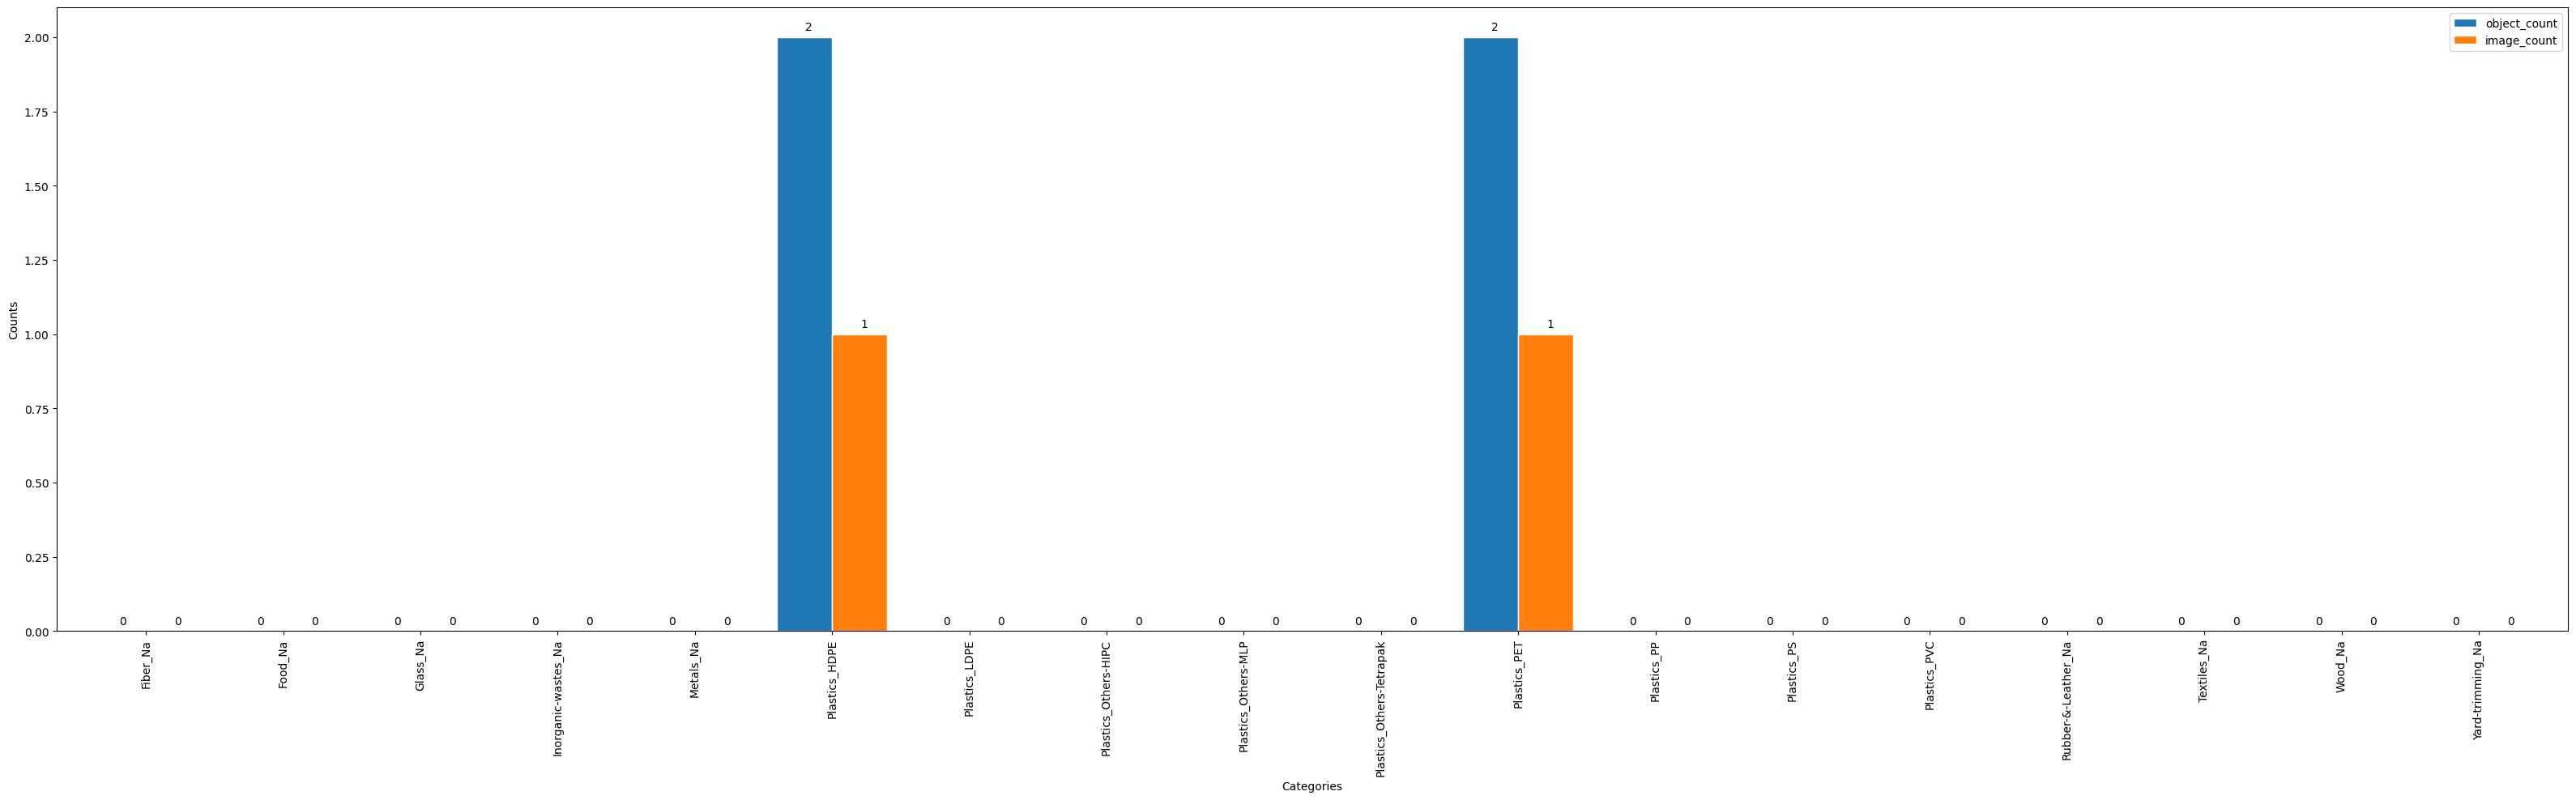

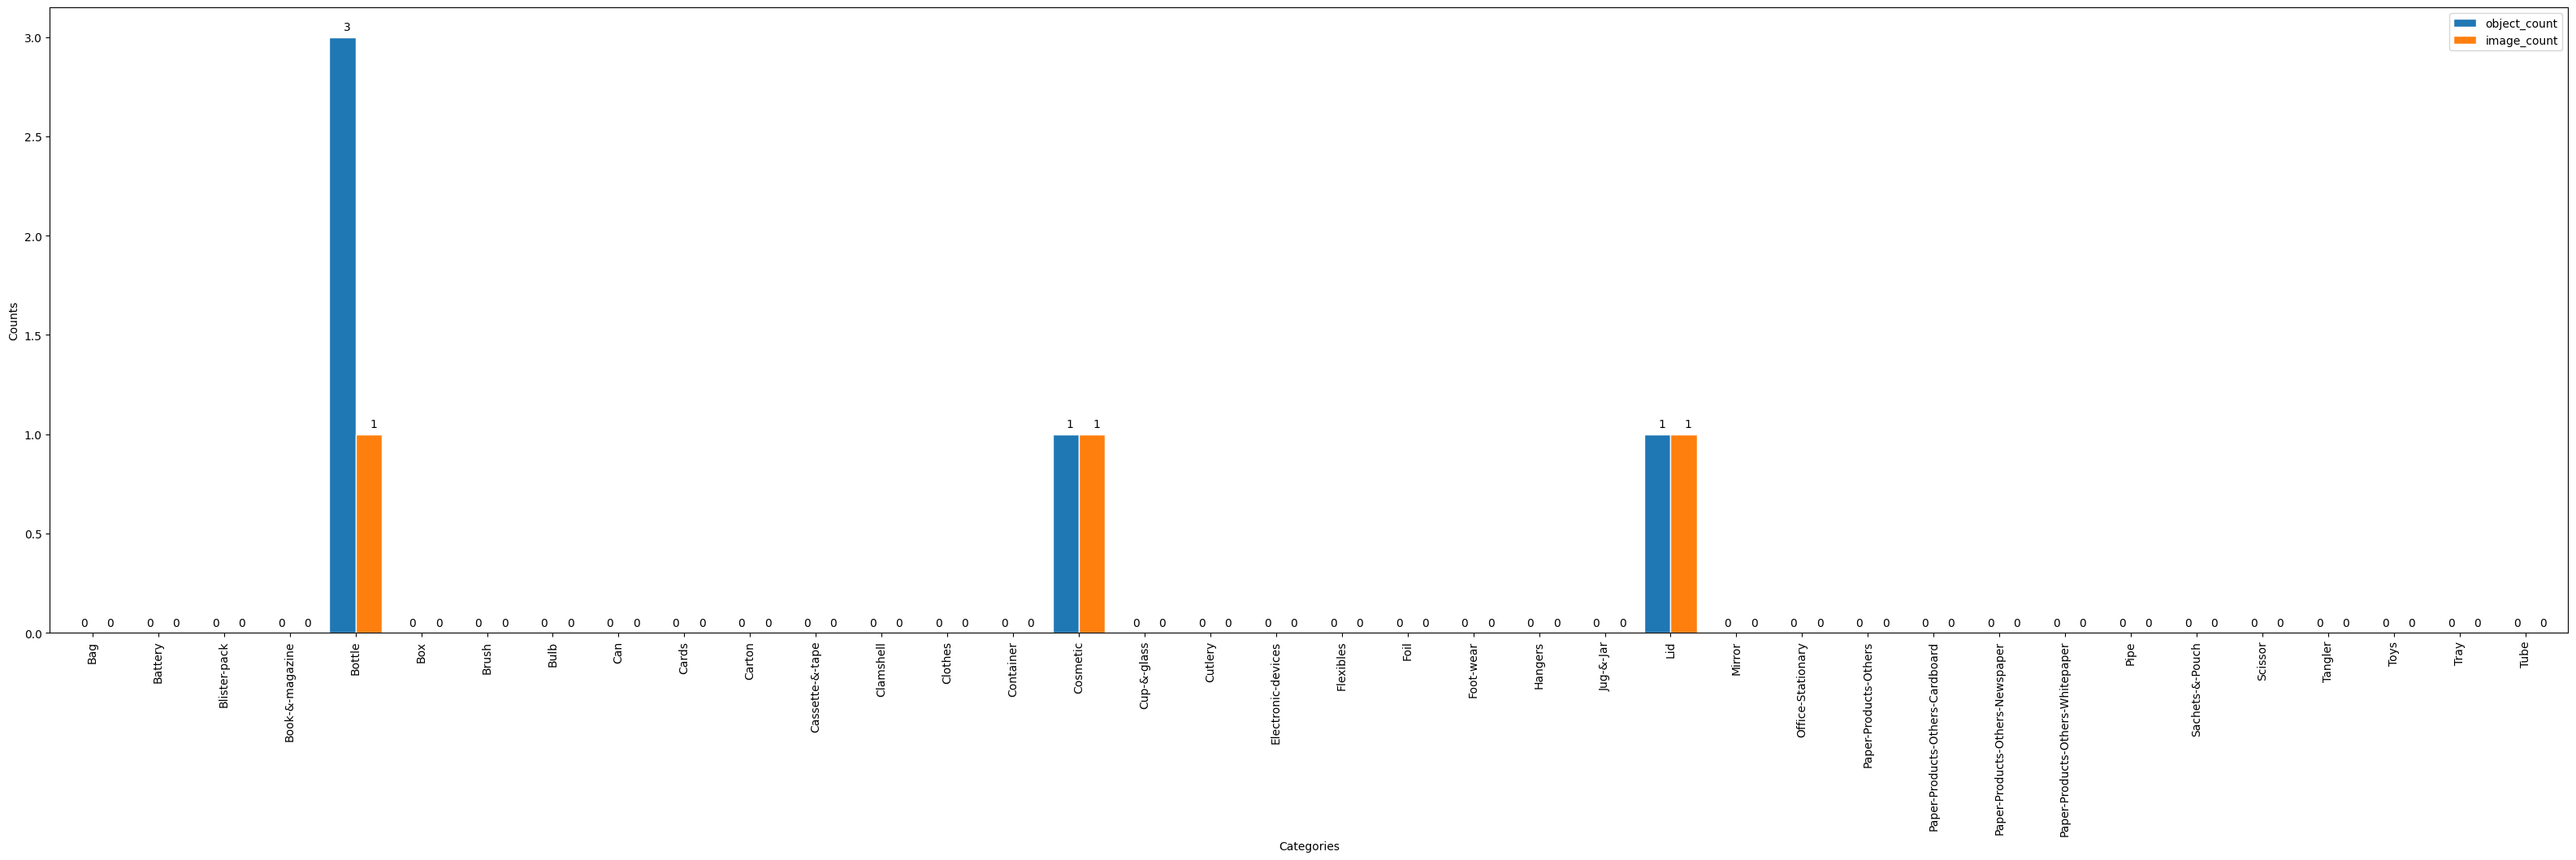

In [ ]:
for file in files:
  print(os.path.basename(file))
  visualize_detailed_counts_horizontally(file)